In [17]:
import numpy as np
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
from CNN_LSTM import CNNLSTM


# 시퀀스 데이터를 생성하는 함수

def create_dataset(sequence, seq_len, pred_len):
    data_x, data_y = [], []
    for i in range(len(sequence) - seq_len - pred_len):
        data_x.append(sequence[i:i+seq_len])
        data_y.append(sequence[i+seq_len:i+seq_len+pred_len])
    return np.array(data_x), np.array(data_y)

def create_data(sequence, seq_len):
    return np.array([sequence[i:i+seq_len] for i in range(len(sequence) - seq_len)])



# FFT 손실 함수 정의   
def fft_loss(pred, target):
    pred_fft = torch.fft.fft(pred, dim=1)
    target_fft = torch.fft.fft(target, dim=1)
    return torch.mean(torch.abs(pred_fft - target_fft))

def plot_fft(signal1, signal2):
    n = min(len(signal1), len(signal2))
    fft1 = np.abs(np.fft.fft(signal1[:n]))
    fft2 = np.abs(np.fft.fft(signal2[:n]))
    freq = np.fft.fftfreq(n)

    plt.figure(figsize=(12, 6))
    plt.plot(freq[:n//2], fft1[:n//2], label="Original FFT")
    plt.plot(freq[:n//2], fft2[:n//2], label="Predicted FFT")
    plt.title("FFT Spectrum Comparison")
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

In [18]:
with open('datas.json', 'r') as f:
    data = json.load(f)

x = np.array(data['timestamp'])
y = np.array(data['value'])

In [28]:
seq_length = 200
pred_length = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNLSTM(input_size=1, hidden_size=128, num_layers=3, output_size=pred_length).to(device)
criterion = nn.MSELoss() # 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


X, Y = create_dataset(y, seq_length, pred_length)

X = torch.FloatTensor(X).view(-1, seq_length, 1).to(device) # (batch_size, seq_len, input_size)
Y = torch.FloatTensor(Y).to(device) # (batch_size, output_size)


In [29]:
torch.manual_seed(0)
np.random.seed(0)

In [30]:
epochs = 500

batch_size = 64
dataset = TensorDataset(X, Y)
dataloader = DataLoader(dataset, batch_size, shuffle=True)
for epoch in range(epochs):
    model.train()
    for i, (X_batch, Y_batch) in enumerate(dataloader):
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        optimizer.zero_grad() # 기울기 초기화
        output = model(X_batch) # 예측값
        mse = criterion(output, Y_batch) # MSE손실 계산
        freq = fft_loss(output, Y_batch) # FFT 손실 계산
        loss = mse + 0.3 * freq # 최종 손실 (FFT 가중치 조정)
        loss.backward() # 역전파
        optimizer.step() # 가중치 업데이트

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10/500], Loss: 0.4262
Epoch [20/500], Loss: 0.4000
Epoch [30/500], Loss: 0.3944
Epoch [40/500], Loss: 0.3920
Epoch [50/500], Loss: 0.3940
Epoch [60/500], Loss: 0.3885
Epoch [70/500], Loss: 0.3644
Epoch [80/500], Loss: 0.3555
Epoch [90/500], Loss: 0.3442
Epoch [100/500], Loss: 0.3381
Epoch [110/500], Loss: 0.3193
Epoch [120/500], Loss: 0.3323
Epoch [130/500], Loss: 0.3332
Epoch [140/500], Loss: 0.3152
Epoch [150/500], Loss: 0.3076
Epoch [160/500], Loss: 0.3053
Epoch [170/500], Loss: 0.3096
Epoch [180/500], Loss: 0.2920
Epoch [190/500], Loss: 0.2977
Epoch [200/500], Loss: 0.2914
Epoch [210/500], Loss: 0.2932
Epoch [220/500], Loss: 0.2865
Epoch [230/500], Loss: 0.2855
Epoch [240/500], Loss: 0.2831
Epoch [250/500], Loss: 0.2870
Epoch [260/500], Loss: 0.2837
Epoch [270/500], Loss: 0.2812
Epoch [280/500], Loss: 0.2862
Epoch [290/500], Loss: 0.2784
Epoch [300/500], Loss: 0.2859
Epoch [310/500], Loss: 0.2728
Epoch [320/500], Loss: 0.2804
Epoch [330/500], Loss: 0.2749
Epoch [340/500], Lo

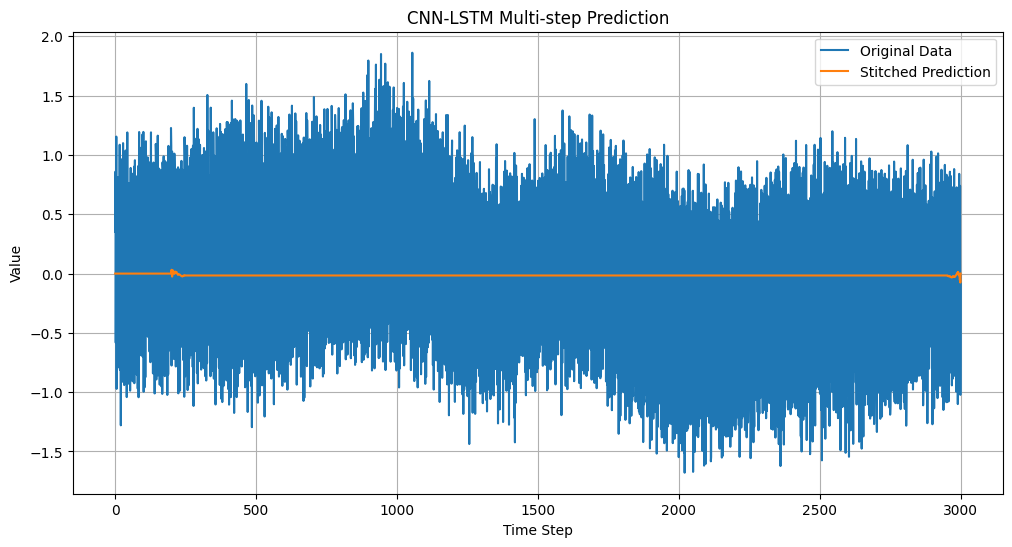

In [13]:
model.eval()
with torch.no_grad():   
    predicted = model(X).data.cpu().numpy() # 예측값

stitched = np.zeros(len(y))
count = np.zeros(len(y))

for i in range(len(predicted)):
    start = seq_length + i
    end = start + pred_length
    if end > len(y):
        break
    stitched[start:end] += predicted[i][:min(pred_length, len(y) - start)]
    count[start:end] += 1
stitched = stitched / np.maximum(count, 1)

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(y, label='Original Data')
plt.plot(stitched, label='Stitched Prediction')
plt.title('CNN-LSTM Multi-step Prediction')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [240]:
torch.save(model.state_dict(), 'model.pt') # 모델 저장

In [27]:
model.load_state_dict(torch.load("model.pt"))
model.to(device)
model.eval()

RuntimeError: Error(s) in loading state_dict for CNNLSTM:
	Missing key(s) in state_dict: "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias". 
	Unexpected key(s) in state_dict: "fc.weight", "fc.bias". 

In [242]:
with open('mixed_frequency_vibration.json', 'r') as f:
    data = json.load(f)

x_test = np.array(data['timestamp'])
y_test = np.array(data['value'])

In [243]:
# 시퀀스 길이 설정 (학습과 동일하게)
seq_length = 200

X_pred, Y_pred = create_dataset(y_test, seq_length, pred_length)
X_pred = torch.FloatTensor(X_pred).view(-1, seq_length, 1).to(device)

In [245]:
with torch.no_grad():   
    predicted = model(X_pred).data.cpu().numpy() # 예측값

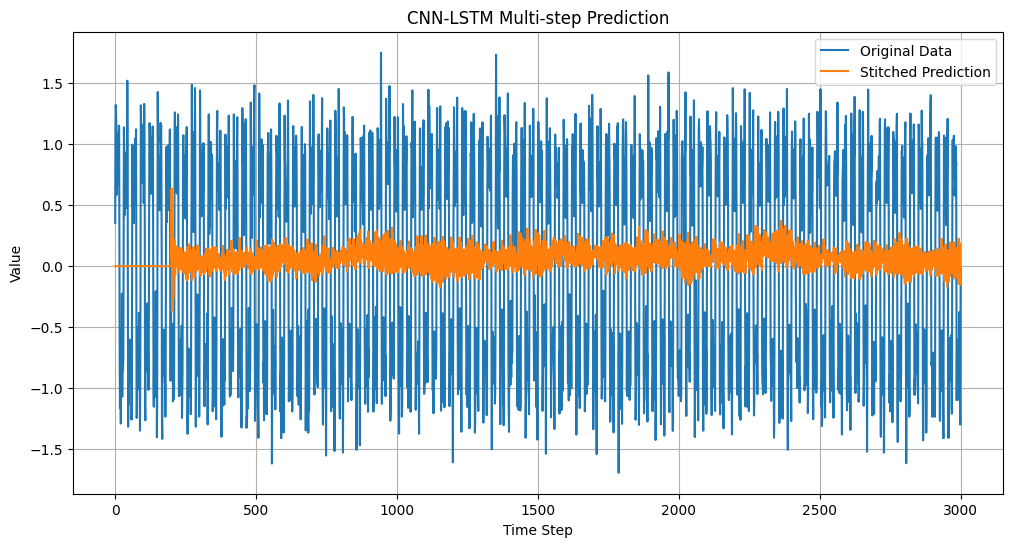

In [246]:
stitched = np.zeros(len(y_test))
count = np.zeros(len(y_test))

for i in range(len(predicted)):
    start = seq_length + i
    end = start + pred_length
    if end > len(y_test):
        break
    stitched[start:end] += predicted[i][:min(pred_length, len(y_test) - start)]
    count[start:end] += 1
stitched = stitched / np.maximum(count, 1)

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Original Data')
plt.plot(stitched, label='Stitched Prediction')
plt.title('CNN-LSTM Multi-step Prediction')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [220]:
print(X_pred.shape)     # 예: (2800, 200, 1)
print(predicted.shape)  # 예: (2800, 1)


torch.Size([2800, 200, 1])
(2800,)


In [222]:
results = {
    "original": y_test.tolist(),
    "predicted": predicted.tolist()
}

with open("predicted_vs_original.json", "w") as f:
    json.dump(results, f, indent=2)

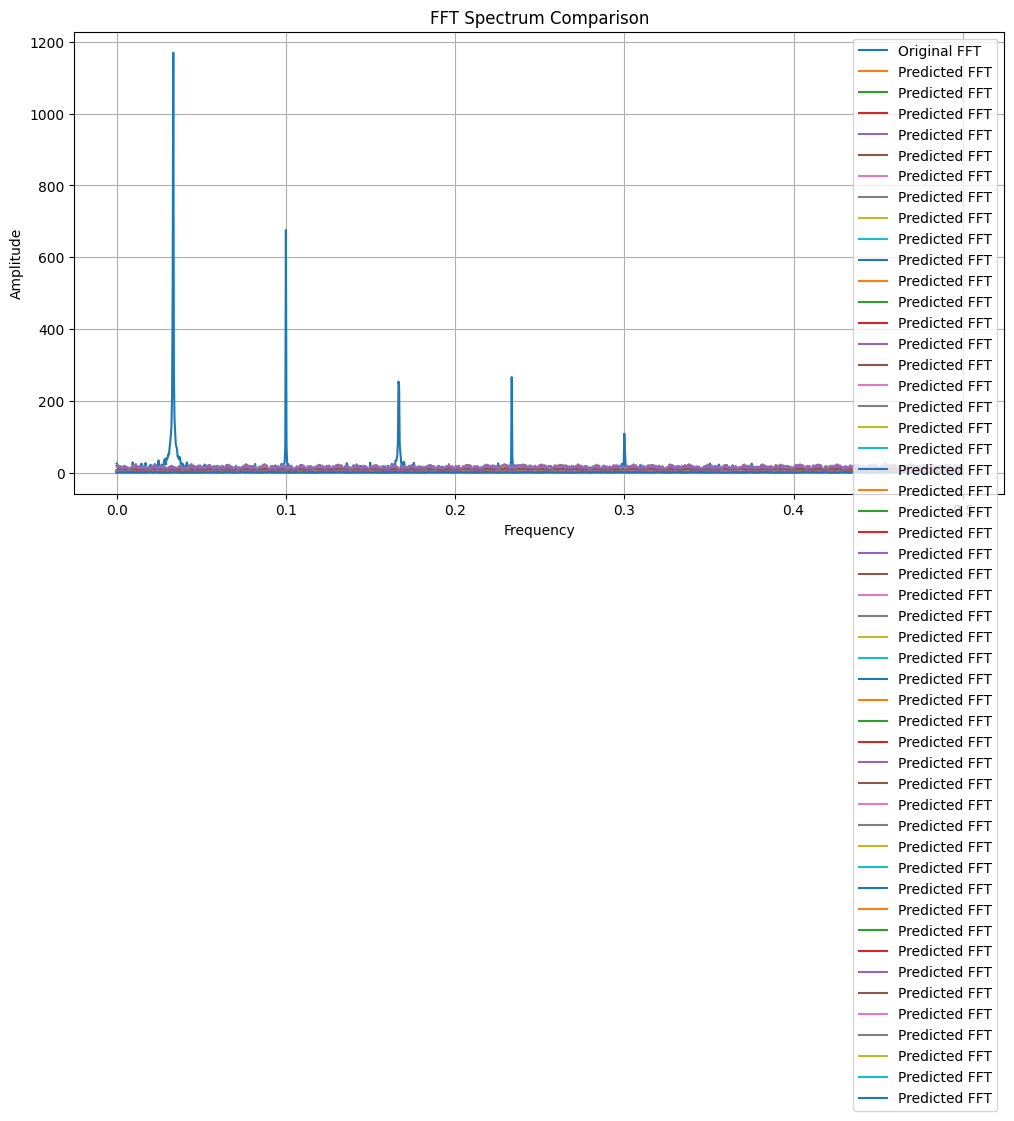

In [247]:
# 신호 길이
N = len(predicted)

# FFT 계산
fft_orig = np.fft.fft(y_test[-N:])        # 마지막 N개 (예측과 일치)
fft_pred = np.fft.fft(predicted)

freq = np.fft.fftfreq(N)

# 절대값 (크기 스펙트럼)
fft_orig_abs = np.abs(fft_orig)
fft_pred_abs = np.abs(fft_pred)

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(freq[:N // 2], fft_orig_abs[:N // 2], label="Original FFT")
plt.plot(freq[:N // 2], fft_pred_abs[:N // 2], label="Predicted FFT")
plt.title("FFT Spectrum Comparison")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()
